# Рекомендательная система по премиум-танкам для игры Tanks Blitz

Суть проекта: предсказывать средний урон игрока на премиум танках основываясь на его статистике игры на обычных танках.

## Загрузка данных

Данные: датасет с информацией о танках и датасет с информацией о статистике игрока на каждом танке.  
В информации о статистике игрока имеются колонки:  
|Колонка|Значение|
| -------- | ------- |
|user_id|ID игрока|
|tank_id|ID танка|
|spotted|Количество обнаруженной техники|
|hits|Количество попаданий|
|frags|Количество уничтоженной техники|
|max_xp|Максимальный опыт за бой|
|wins|Количество побед|
|losses|Количество поражений|
|capture_points|Очки захвата базы|
|battles|Количество боёв|
|damage_dealt|Нанесённый урон|
|damage_received|Полученный урон|
|max_frags|Максимум уничтожено за бой|
|shots|Произведено выстрелов|
|frags8p|Количество уничтоженной техники (уровень >=8)|
|xp|Суммарный опыт|
|win_and_survived|Выжил в боях и победил|
|survived_battles|Выжил в боях|
|dropped_capture_points|Очки защиты базы|
|battle_life_time|Общее время в боях в секундах|
|mark_of_mastery|Знаки классности:<br>— 0 — Отсутствует<br>— 1 — 3 степень<br>— 2 — 2 степень<br>— 3 — 1 степень<br>— 4 — Мастер|

In [1]:
import gc
import os
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import joblib
from autogluon.tabular import TabularDataset, TabularPredictor
from flaml import AutoML
from loguru import logger
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    root_mean_squared_error,
    root_mean_squared_log_error,
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
premium_df = pd.read_csv("../data/premium_tanks.csv")
premium_df.head()

,tank_id,nation,tier,type,name,default_profile.firepower,default_profile.hp,default_profile.hull_hp,default_profile.hull_weight,default_profile.maneuverability,...,default_profile.gun.move_up_arc,default_profile.gun.reload_time,default_profile.gun.traverse_speed,default_profile.suspension.load_limit,default_profile.suspension.traverse_speed,default_profile.turret.hp,default_profile.turret.traverse_left_arc,default_profile.turret.traverse_right_arc,default_profile.turret.traverse_speed,default_profile.turret.view_range
0,3073,ussr,3,lightTank,Т-46,21,480,384,7800,72,...,16,9.00,43.75,17300,48,96,180,180,44,220
1,8049,other,5,mediumTank,Шип,30,650,496,12292,47,...,25,7.80,35.00,25000,33,154,180,180,40,240
2,63841,japan,5,mediumTank,Panzer IV Lightning,29,710,568,11270,48,...,20,8.04,35.00,28000,35,142,180,180,48,240
3,52513,usa,7,heavyTank,M6A2E1,47,1400,1120,36550,30,...,20,10.50,35.00,70500,25,280,180,180,25,250
4,6481,uk,4,lightTank,Covenanter,29,600,480,9510,50,...,20,10.00,43.75,20500,40,120,180,180,48,230


In [3]:
general_df = pd.read_csv("../data/general_tanks.csv")
general_df.head()

,tank_id,nation,tier,type,name
0,1,ussr,5,mediumTank,Т-34
1,17,germany,5,mediumTank,Pz.Kpfw. IV Ausf. G
2,1569,usa,7,mediumTank,T20
3,8225,usa,8,AT-SPG,T28
4,1297,germany,7,mediumTank,Panther I


In [4]:
files = os.listdir("../data/15.11/")

In [5]:
df = pd.DataFrame()
for file in files:
    logger.info(f"Load: {file}")
    temp = pd.read_csv(f"../data/15.11/{file}")
    df = pd.concat([df, temp])

2025-11-21 21:27:20.591 | INFO     | __main__:<module>:3 - Load: users_1.csv
2025-11-21 21:27:22.241 | INFO     | __main__:<module>:3 - Load: users_2.csv
2025-11-21 21:27:22.323 | INFO     | __main__:<module>:3 - Load: users_3.csv
2025-11-21 21:27:24.879 | INFO     | __main__:<module>:3 - Load: users_4.csv
2025-11-21 21:27:26.460 | INFO     | __main__:<module>:3 - Load: users_5.csv
2025-11-21 21:27:26.681 | INFO     | __main__:<module>:3 - Load: users_6.csv


In [6]:
df.shape

(5558394, 21)

In [7]:
df.head()

,user_id,tank_id,spotted,hits,frags,max_xp,wins,losses,capture_points,battles,...,damage_received,max_frags,shots,frags8p,xp,win_and_survived,survived_battles,dropped_capture_points,battle_life_time,mark_of_mastery
0,53,11025,68,541,92,1629,76,66,189,142,...,117370,4,721,15,87274,43,43,104,23179,4
1,53,54801,3,48,2,478,3,2,0,5,...,1683,1,69,0,1294,2,2,0,645,1
2,53,54865,5,144,1,669,1,1,3,2,...,464,1,240,0,810,1,1,0,374,2
3,53,16657,1,21,3,629,2,4,0,6,...,6600,2,27,2,2142,0,0,0,937,0
4,53,1809,32,186,43,1458,24,16,116,40,...,13120,5,237,0,22098,21,21,28,7082,4


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5558394 entries, 0 to 84403
Data columns (total 21 columns):
 #   Column                  Dtype
---  ------                  -----
 0   user_id                 int64
 1   tank_id                 int64
 2   spotted                 int64
 3   hits                    int64
 4   frags                   int64
 5   max_xp                  int64
 6   wins                    int64
 7   losses                  int64
 8   capture_points          int64
 9   battles                 int64
 10  damage_dealt            int64
 11  damage_received         int64
 12  max_frags               int64
 13  shots                   int64
 14  frags8p                 int64
 15  xp                      int64
 16  win_and_survived        int64
 17  survived_battles        int64
 18  dropped_capture_points  int64
 19  battle_life_time        int64
 20  mark_of_mastery         int64
dtypes: int64(21)
memory usage: 933.0 MB


In [9]:
df = df.astype("int32")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5558394 entries, 0 to 84403
Data columns (total 21 columns):
 #   Column                  Dtype
---  ------                  -----
 0   user_id                 int32
 1   tank_id                 int32
 2   spotted                 int32
 3   hits                    int32
 4   frags                   int32
 5   max_xp                  int32
 6   wins                    int32
 7   losses                  int32
 8   capture_points          int32
 9   battles                 int32
 10  damage_dealt            int32
 11  damage_received         int32
 12  max_frags               int32
 13  shots                   int32
 14  frags8p                 int32
 15  xp                      int32
 16  win_and_survived        int32
 17  survived_battles        int32
 18  dropped_capture_points  int32
 19  battle_life_time        int32
 20  mark_of_mastery         int32
dtypes: int32(21)
memory usage: 487.7 MB


## Очистка данных

In [10]:
df.describe()

,user_id,tank_id,spotted,hits,frags,max_xp,wins,losses,capture_points,battles,...,damage_received,max_frags,shots,frags8p,xp,win_and_survived,survived_battles,dropped_capture_points,battle_life_time,mark_of_mastery
count,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,...,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06,5.558394e+06
mean,8.467542e+07,9.733482e+03,4.758929e+01,2.933969e+02,3.552320e+01,8.764450e+02,2.414456e+01,2.329370e+01,2.169797e+01,4.786314e+01,...,5.077141e+04,2.668772e+00,3.686920e+02,1.517869e+01,2.912748e+04,1.454547e+01,1.505565e+01,3.791859e+01,7.903093e+03,1.756844e+00
std,6.093647e+07,1.346255e+04,1.562982e+02,8.818239e+02,1.203349e+02,5.816408e+02,7.506136e+01,7.206143e+01,7.211325e+01,1.465164e+02,...,2.030665e+05,1.571634e+00,1.101370e+03,9.300429e+01,1.068817e+05,4.776878e+01,4.922651e+01,1.005021e+02,2.532928e+04,1.217565e+00
min,5.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.902980e+05,1.921000e+03,2.000000e+00,2.800000e+01,2.000000e+00,4.010000e+02,2.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,...,1.047000e+03,2.000000e+00,3.700000e+01,0.000000e+00,9.200000e+02,1.000000e+00,1.000000e+00,0.000000e+00,5.600000e+02,1.000000e+00
50%,1.002095e+08,5.185000e+03,1.000000e+01,9.200000e+01,9.000000e+00,7.510000e+02,6.000000e+00,6.000000e+00,0.000000e+00,1.200000e+01,...,5.822000e+03,3.000000e+00,1.200000e+02,0.000000e+00,4.587000e+03,4.000000e+00,4.000000e+00,4.000000e+00,2.016000e+03,2.000000e+00
75%,1.500831e+08,1.152100e+04,4.100000e+01,2.770000e+02,3.200000e+01,1.295000e+03,2.300000e+01,2.200000e+01,7.000000e+00,4.500000e+01,...,3.426600e+04,4.000000e+00,3.520000e+02,0.000000e+00,2.307200e+04,1.300000e+01,1.400000e+01,4.100000e+01,7.123000e+03,3.000000e+00
max,2.504681e+08,6.537700e+04,3.507500e+04,2.159840e+05,4.037900e+04,4.294000e+03,2.127500e+04,1.734100e+04,1.641200e+04,3.700700e+04,...,4.643575e+07,9.000000e+00,2.535230e+05,2.747100e+04,3.138752e+07,1.577500e+04,1.615600e+04,3.048600e+04,5.926769e+06,4.000000e+00


In [11]:
premium_df.tank_id.nunique()

283

In [12]:
general_df.tank_id.nunique()

240

Можем заметить, что всего имеется информация о 523 танках, в то время, как в статистике игроков 649 уникальных танков (это могут быть как тестовые танки, так и танки, котоыре выведены из игры и которых нет у игроков).

In [13]:
# оставим только актуальные танки игры
tanks_ids = np.concatenate((premium_df.tank_id.values, general_df.tank_id.values))
df = df[df.tank_id.isin(tanks_ids)]

In [14]:
# удаляем записи, в которых число боев меньше чем сумма побед и поражений или равно 0
df = df.query("(battles >= wins + losses) & (battles > 0)")

In [15]:
df.isna().sum()

user_id                   0
tank_id                   0
spotted                   0
hits                      0
frags                     0
max_xp                    0
wins                      0
losses                    0
capture_points            0
battles                   0
damage_dealt              0
damage_received           0
max_frags                 0
shots                     0
frags8p                   0
xp                        0
win_and_survived          0
survived_battles          0
dropped_capture_points    0
battle_life_time          0
mark_of_mastery           0
dtype: int64

## EDA

In [16]:
# Количество премиум-танков
len(premium_df.tank_id.values)

283

In [17]:
# Количество обычных танков
len(general_df.tank_id.values)

240

In [18]:
# Смотрим, по какому количеству премиум танков у нас есть данные
df[df.tank_id.isin(premium_df.tank_id.values)].tank_id.nunique()

282

In [19]:
# Проверим по скольки обычным танкам у нас остались данные после фильтрации
df[df.tank_id.isin(general_df.tank_id.values)].tank_id.nunique()

240

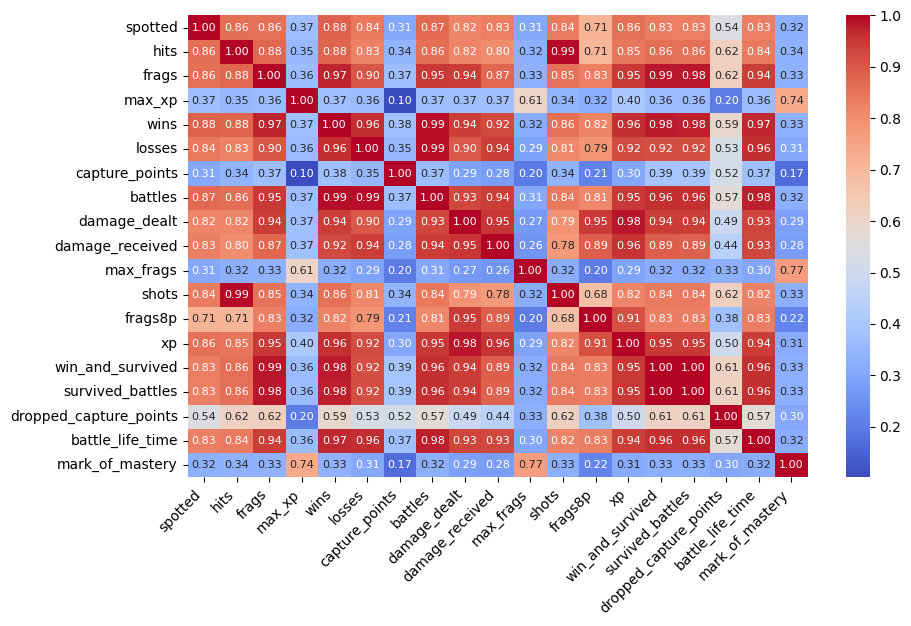

In [20]:
corrs = df.drop(["user_id", "tank_id"], axis=1).corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corrs, annot=True, fmt=".2f", ax=ax, cmap="coolwarm", annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

Как можно заметить, много где высокие значения корреляций. К сожалению, это неизбежно из-за особенностей самих данных. Так, с ростом количества боев неизбежно будут изменяться и другие параметры, а изменение будет зависеть от действий игрока в бою. Точно также, связь win_and_survived и survived_battles, хоть они и имеют очень высокую корреляцию, но удаление одной из них невозможно, т.к. их комбинация позволяет делать выводы о ситуации, когда игрок победил, но не выжил в бою, либо выжил, но проиграл.

In [21]:
# т.к. многие колонки являются постоянно растущими значениями, то усредним их на количество боев
avg_cols = df.drop(
    ["user_id", "tank_id", "max_xp", "battles", "max_frags", "mark_of_mastery"], axis=1
).columns
df[avg_cols] = df[avg_cols].div(df["battles"], axis=0).astype("float32")

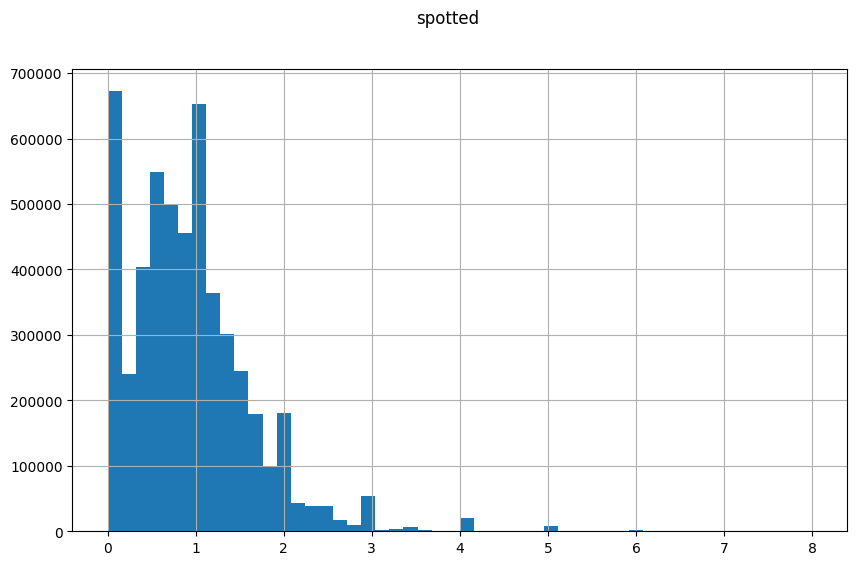

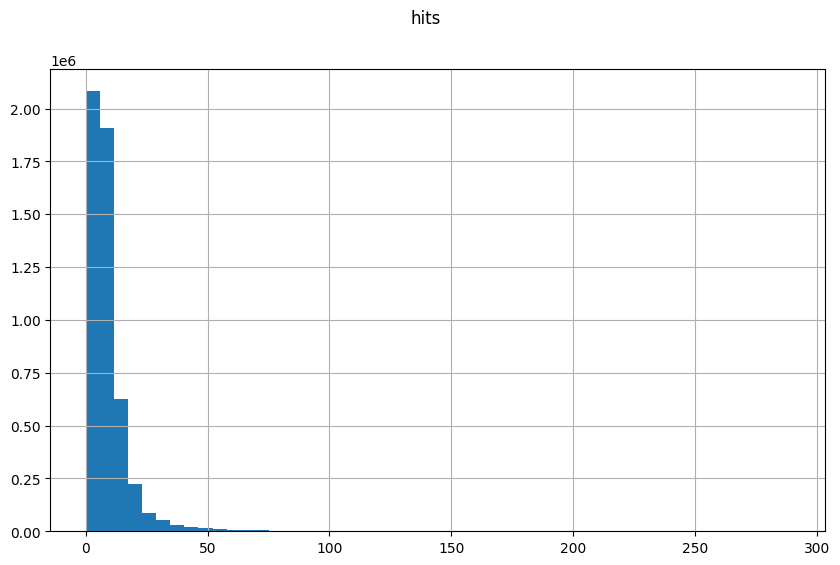

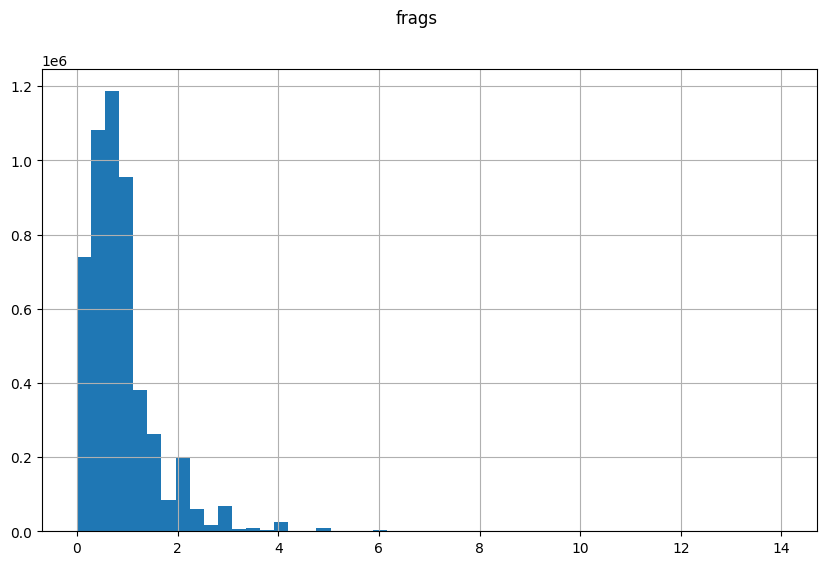

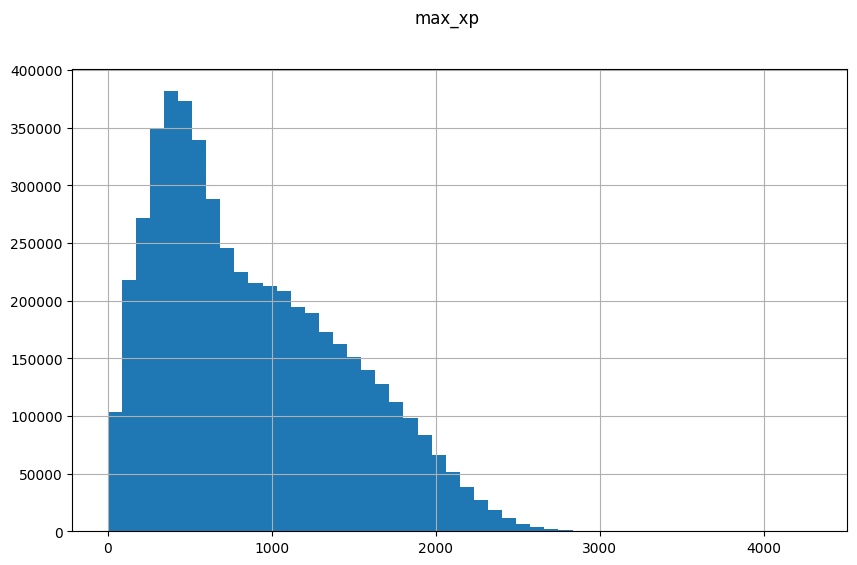

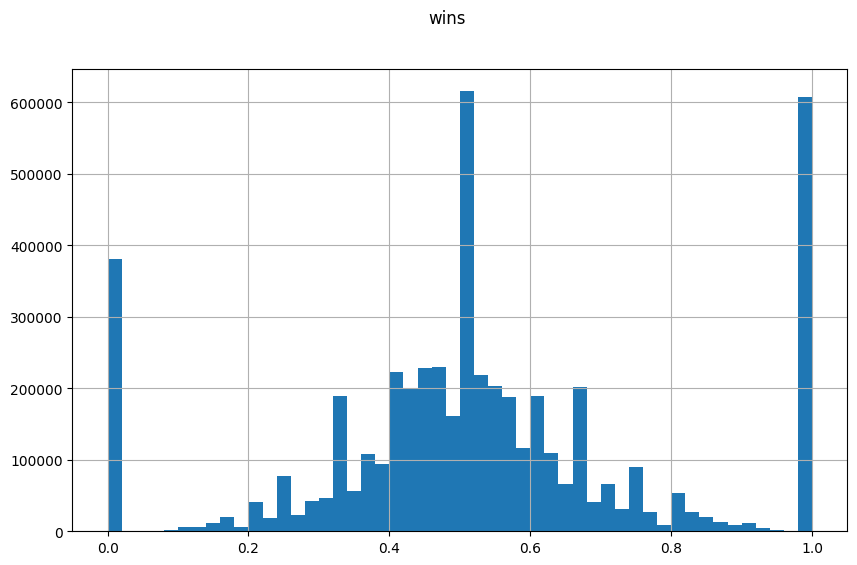

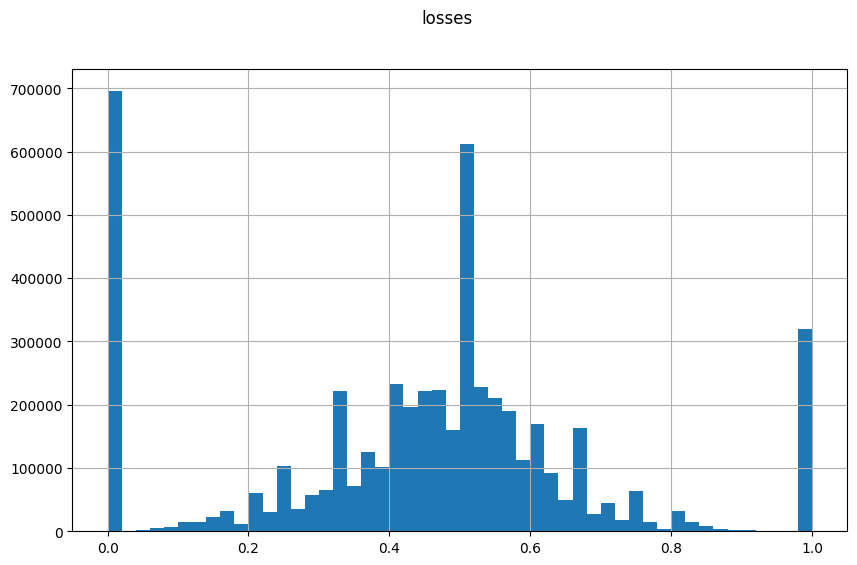

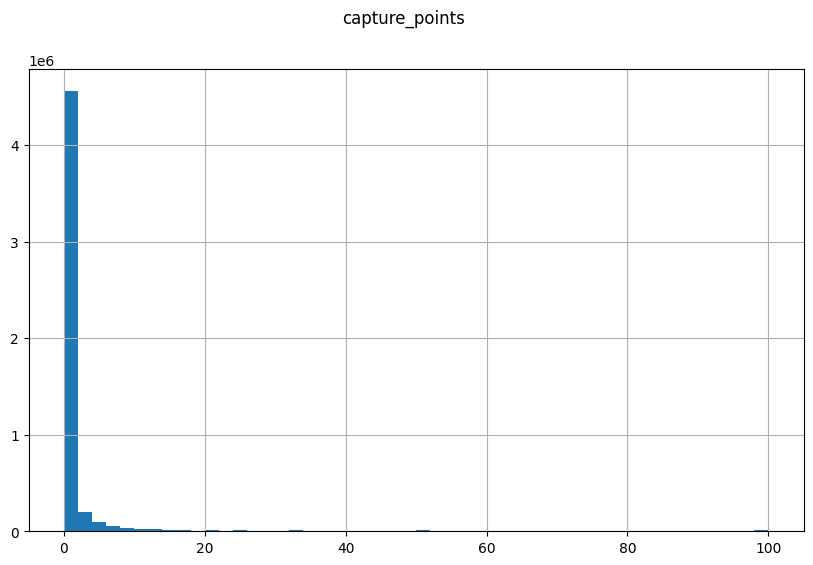

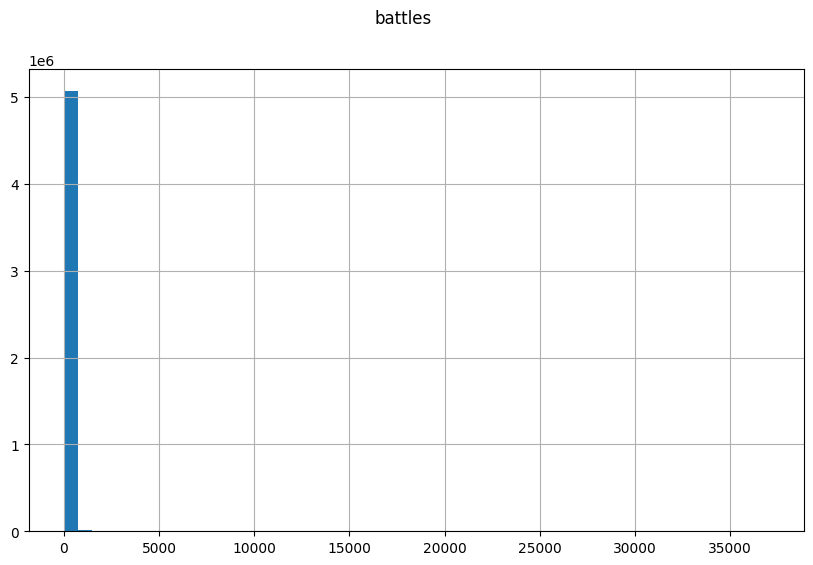

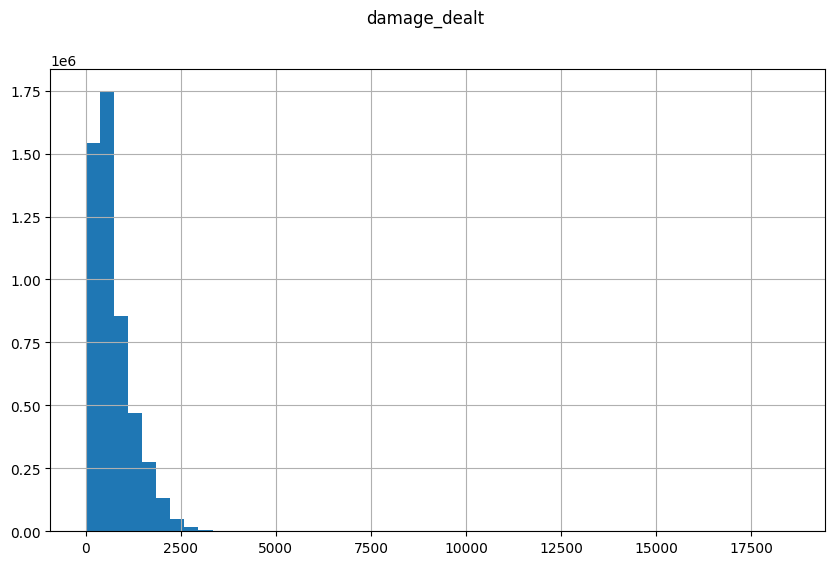

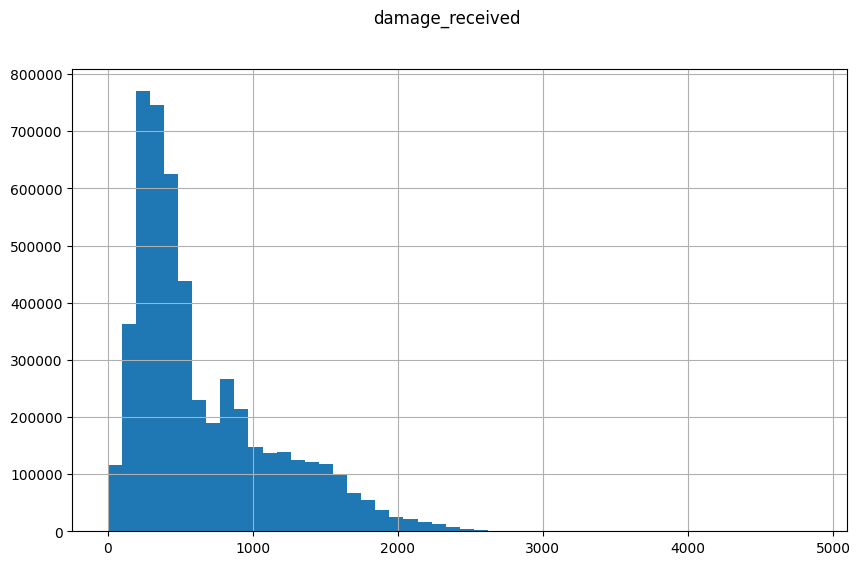

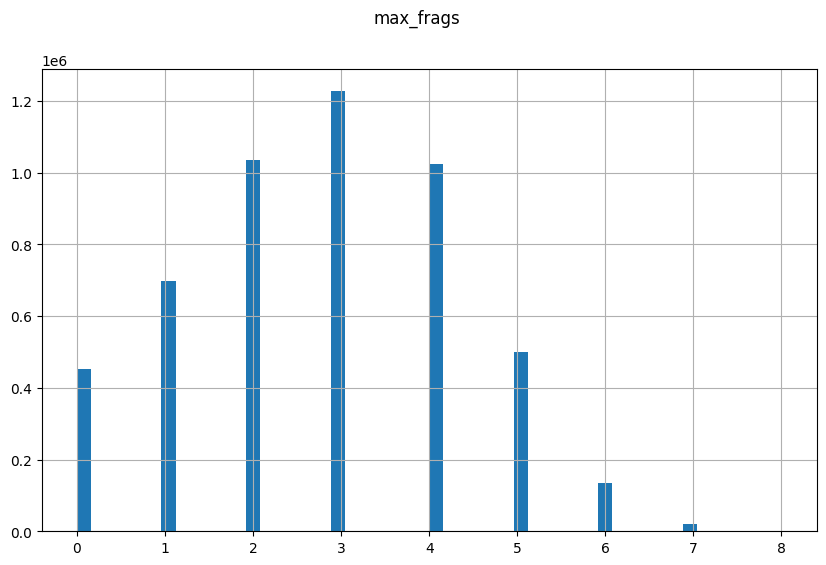

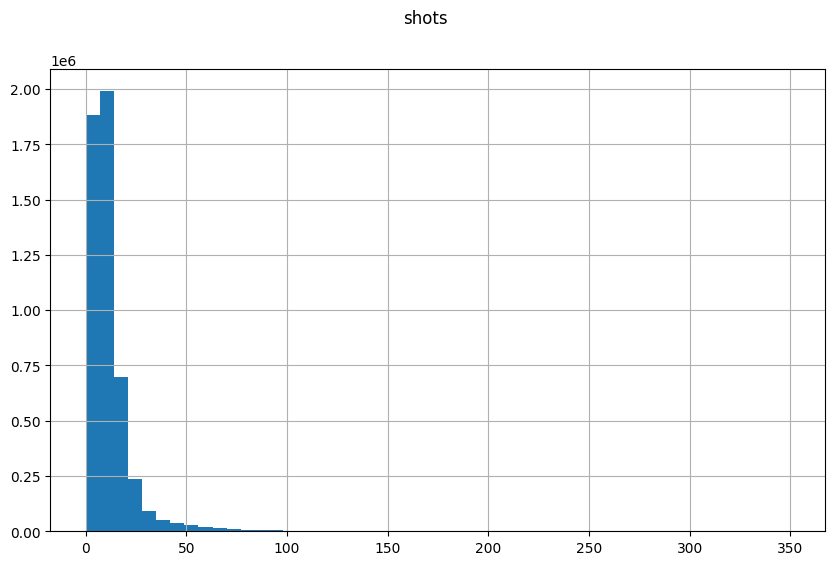

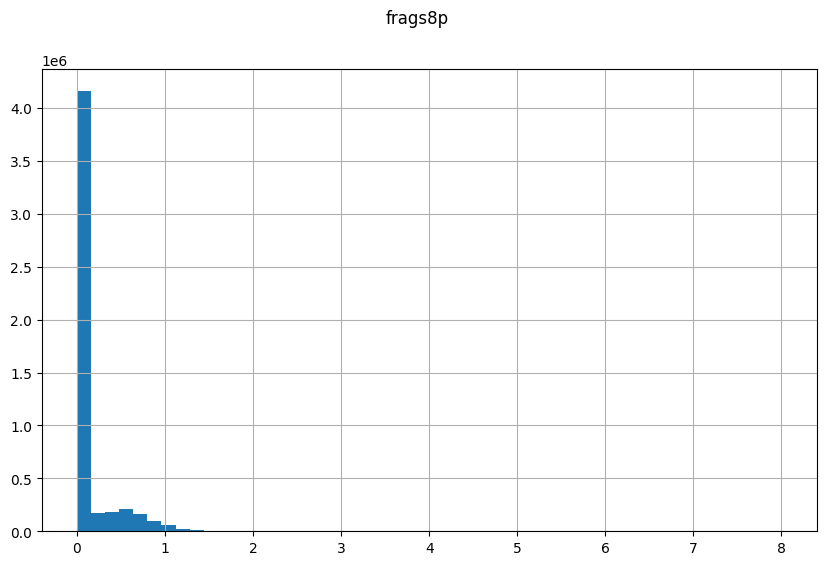

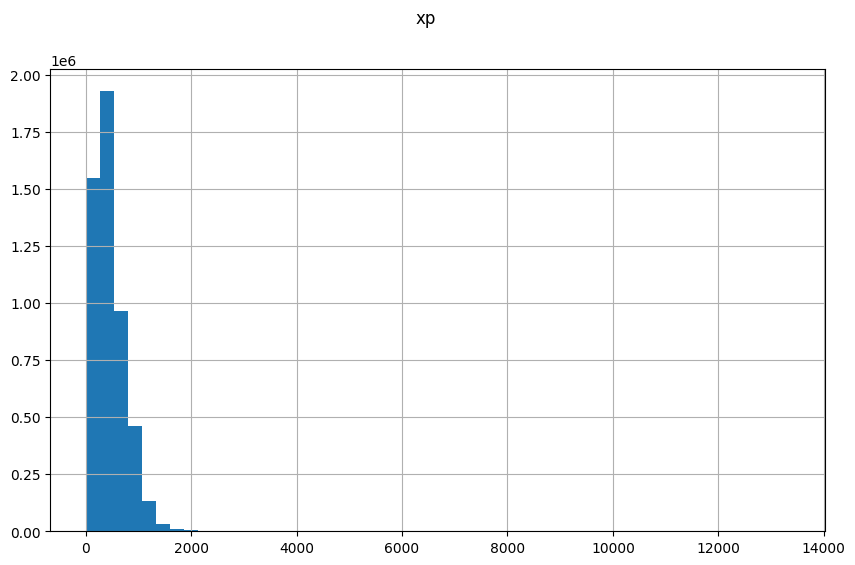

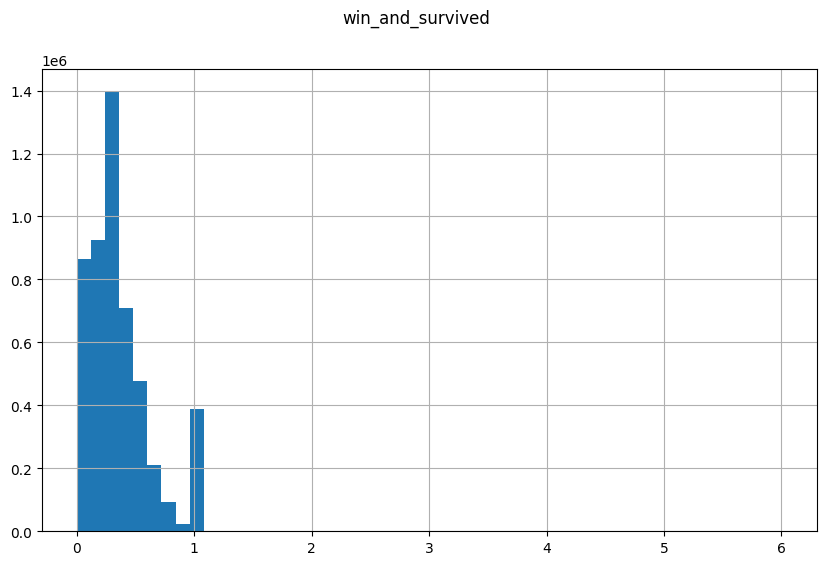

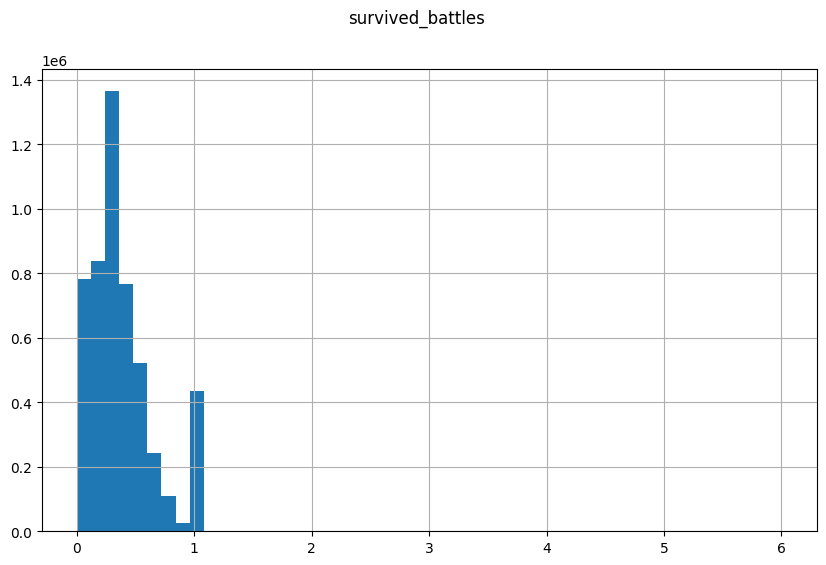

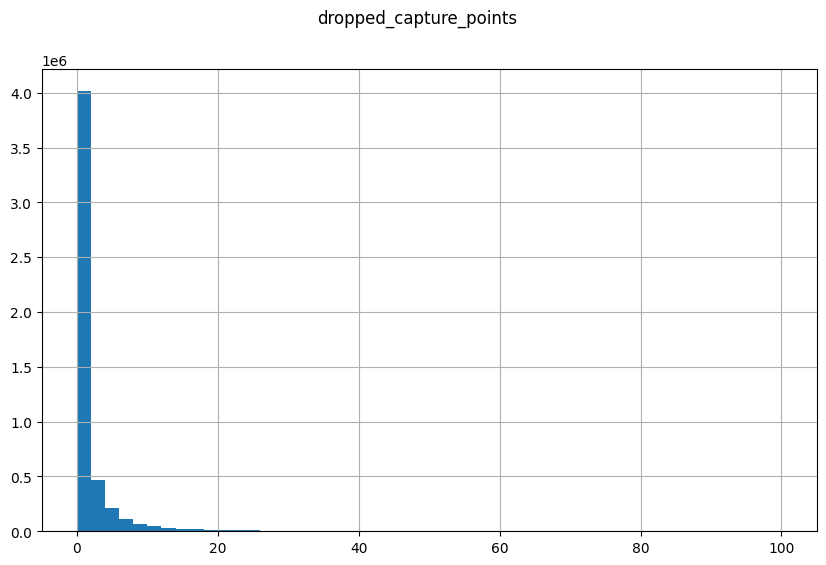

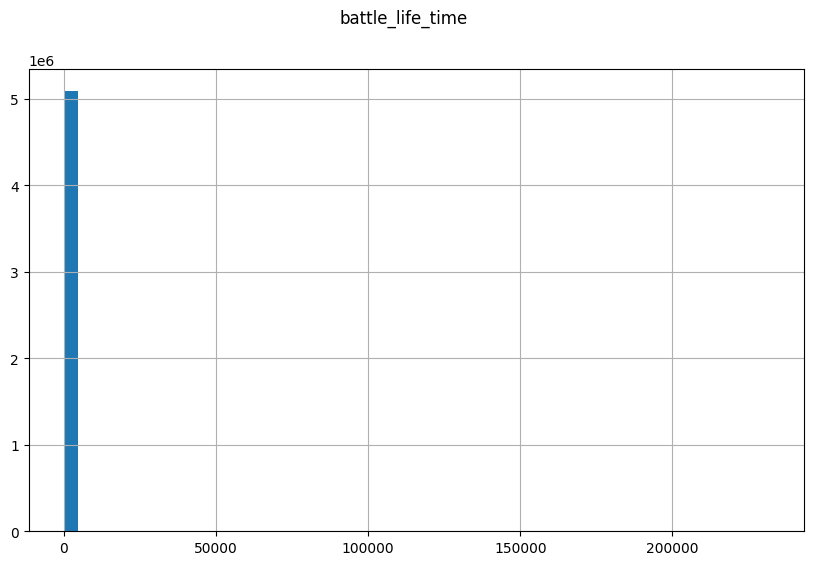

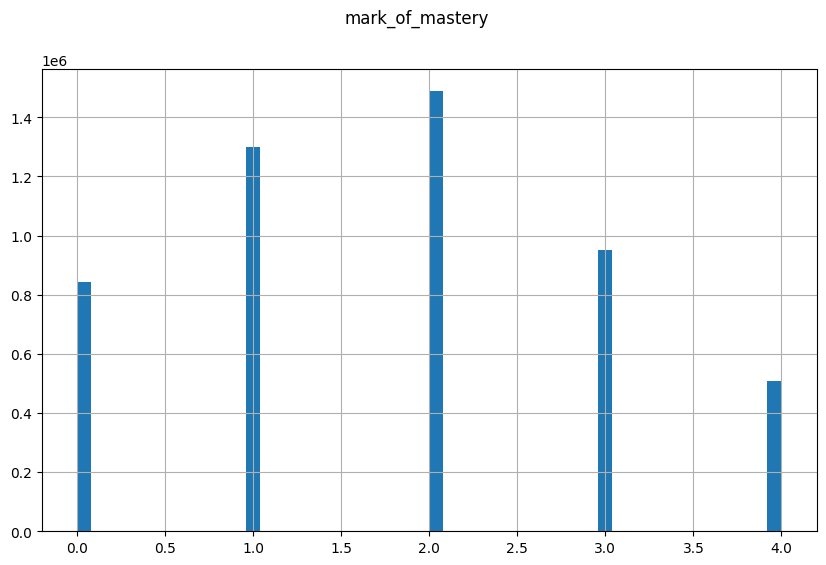

In [22]:
for col in df.drop(["user_id", "tank_id"], axis=1).columns:
    df[col].hist(bins=50, figsize=(10, 6))
    plt.suptitle(f"{col}")
    plt.show()

Исходя из графиков видно, что распределения близки к нормальному или логнормальному респределениям. Однако, на графиках с победами и поражениями есть большие хвосты в районах 0 и 1, предположительно это влияние того, что игрок сыграл малое количество боев (например, всего 1). Посмотрим на графики если отфильтровать данные на минимальное количество боев.

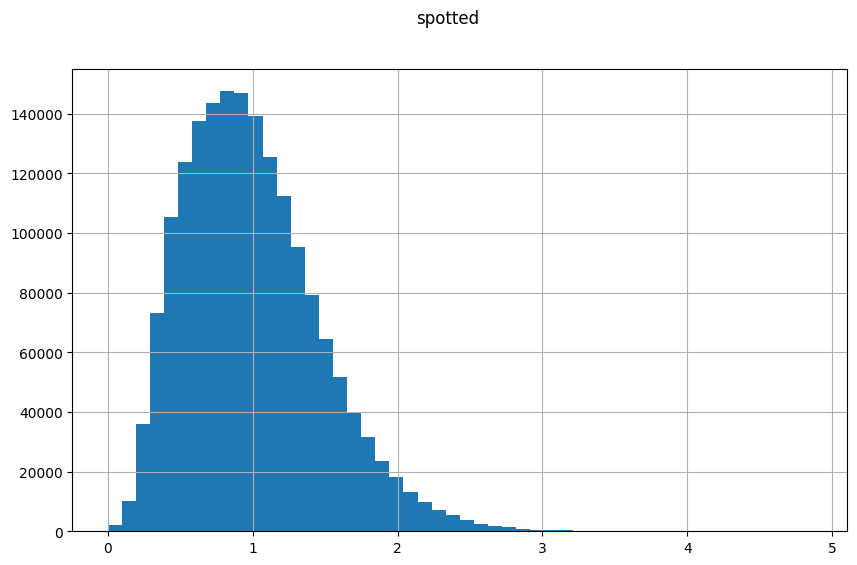

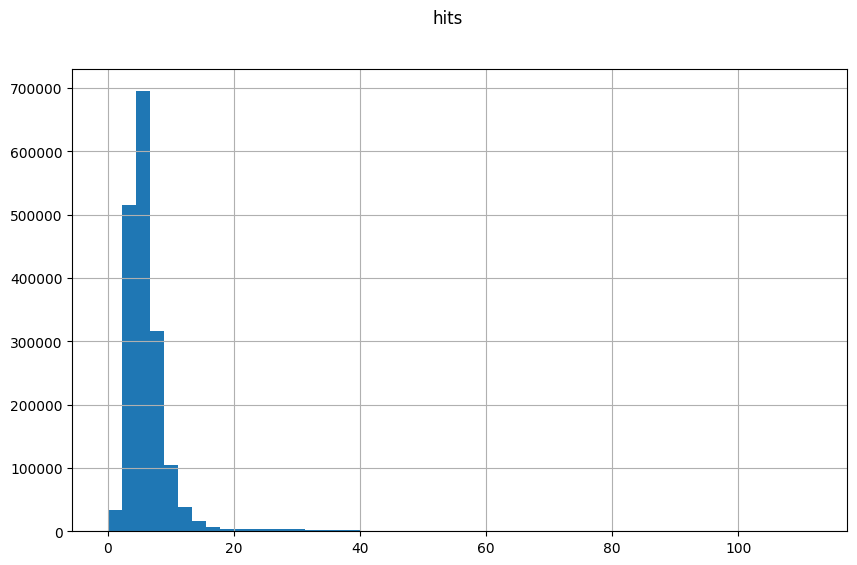

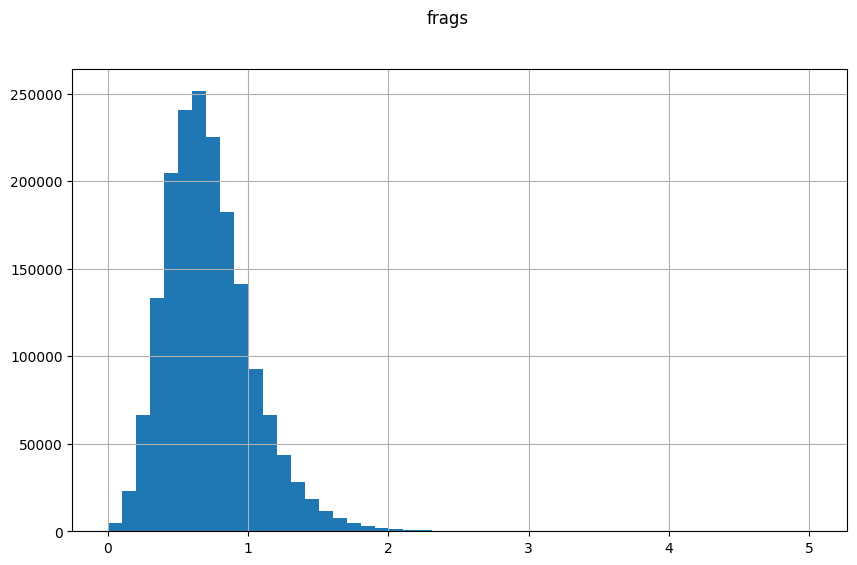

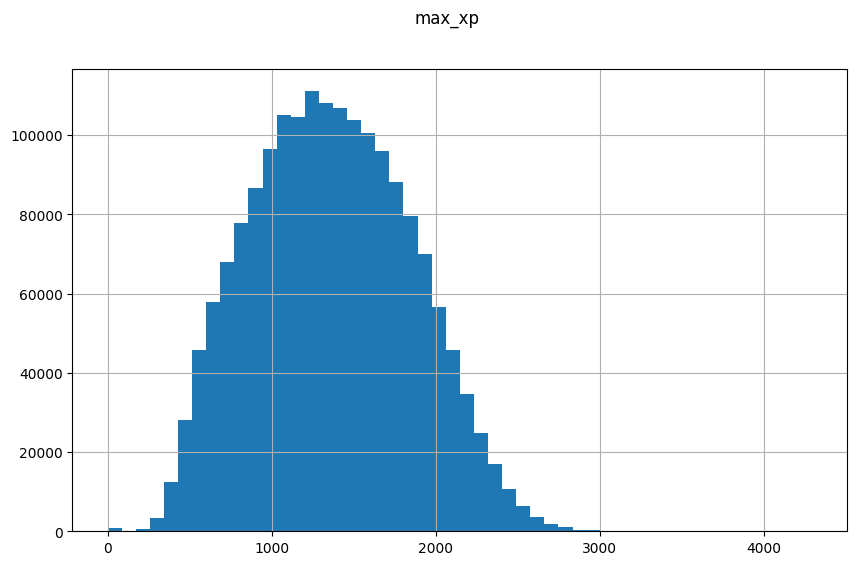

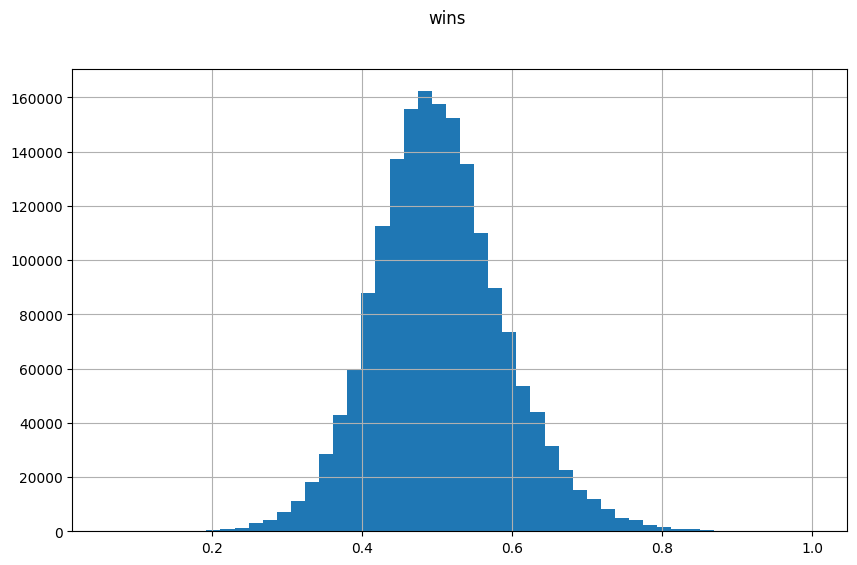

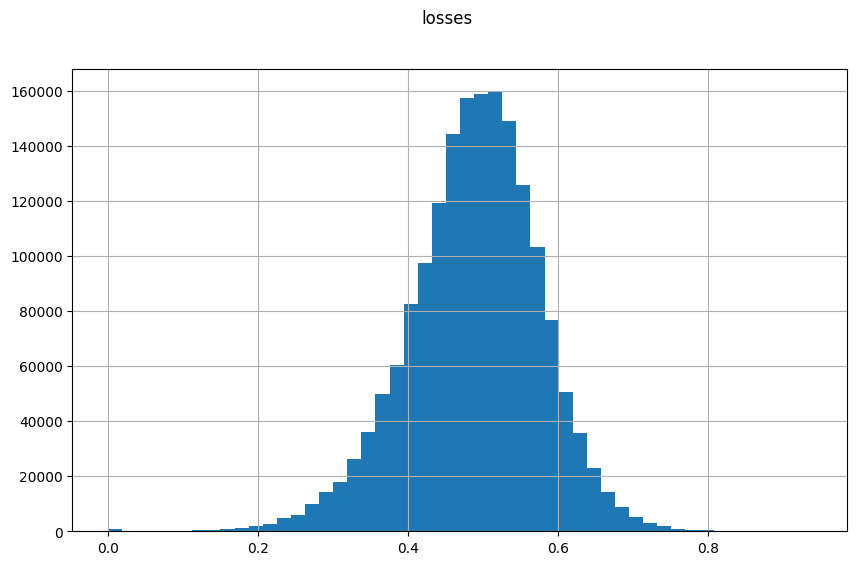

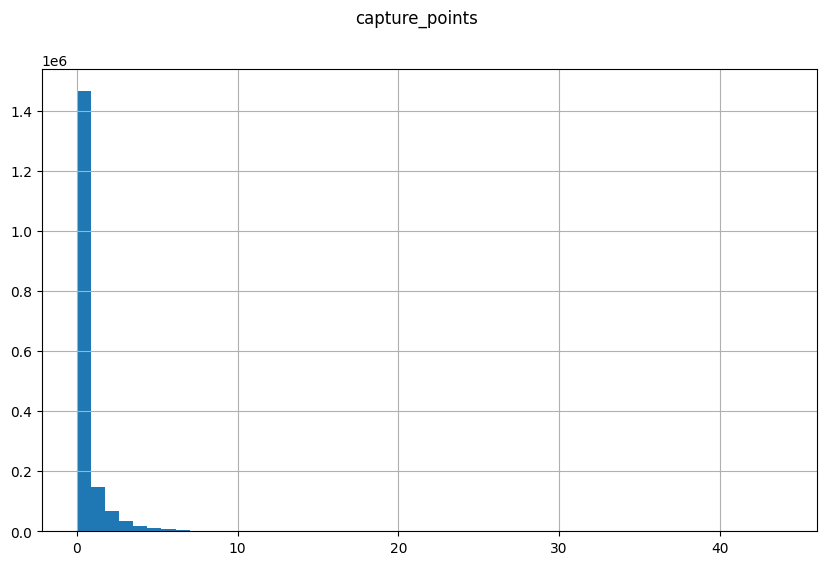

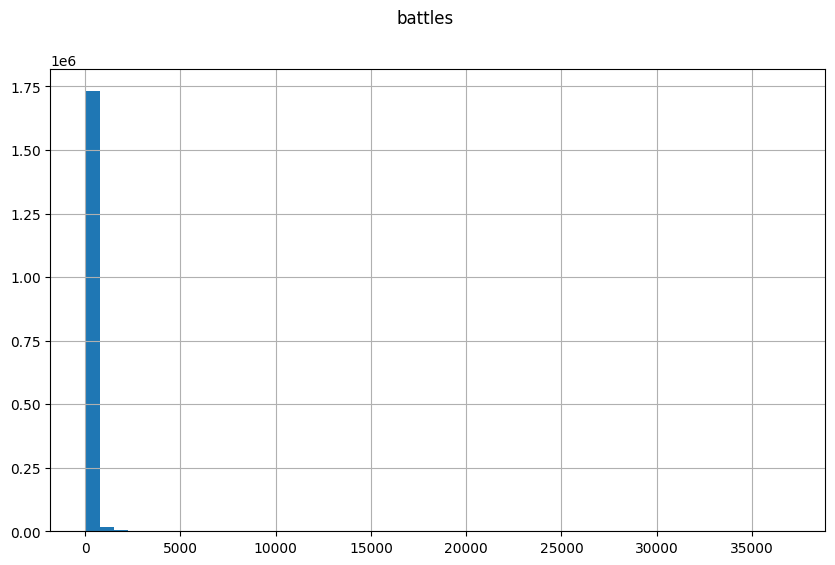

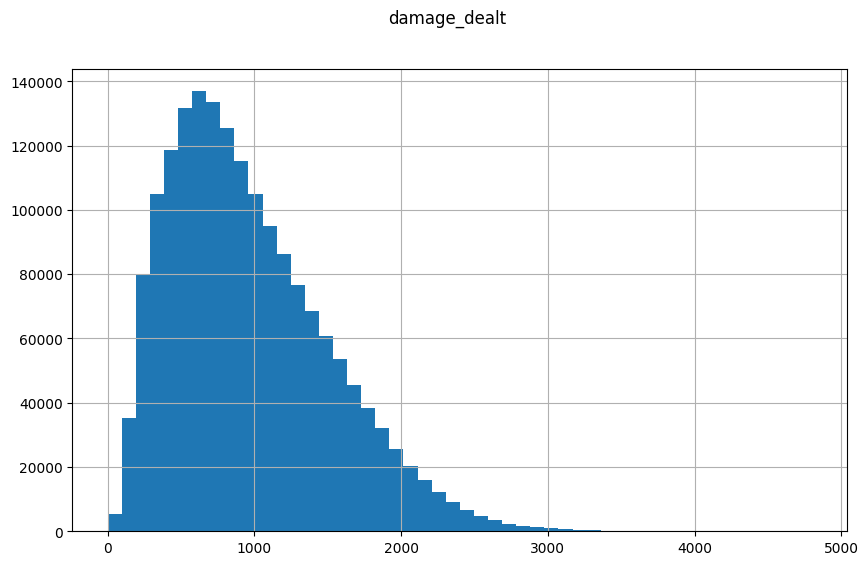

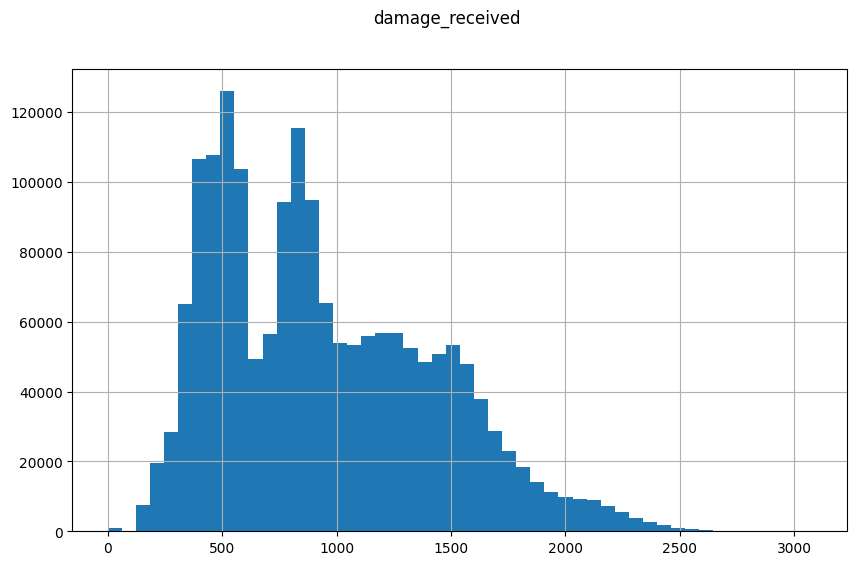

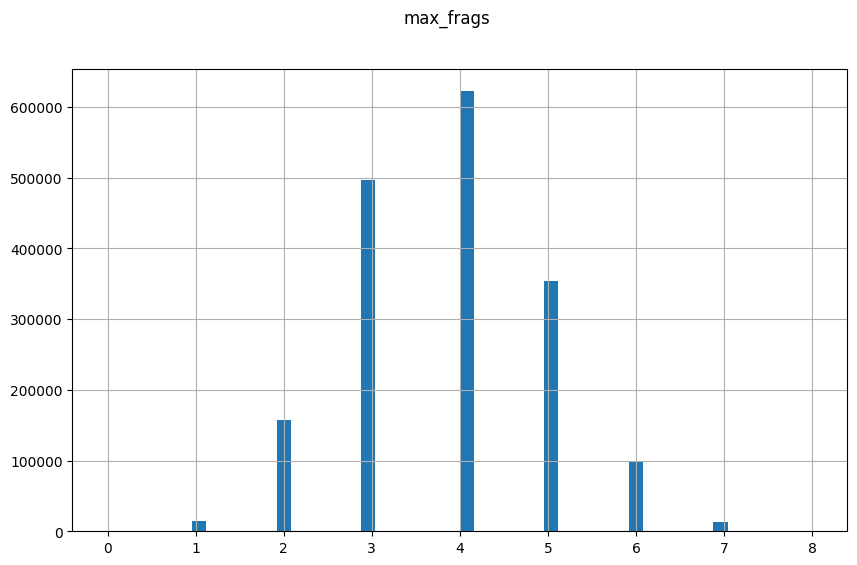

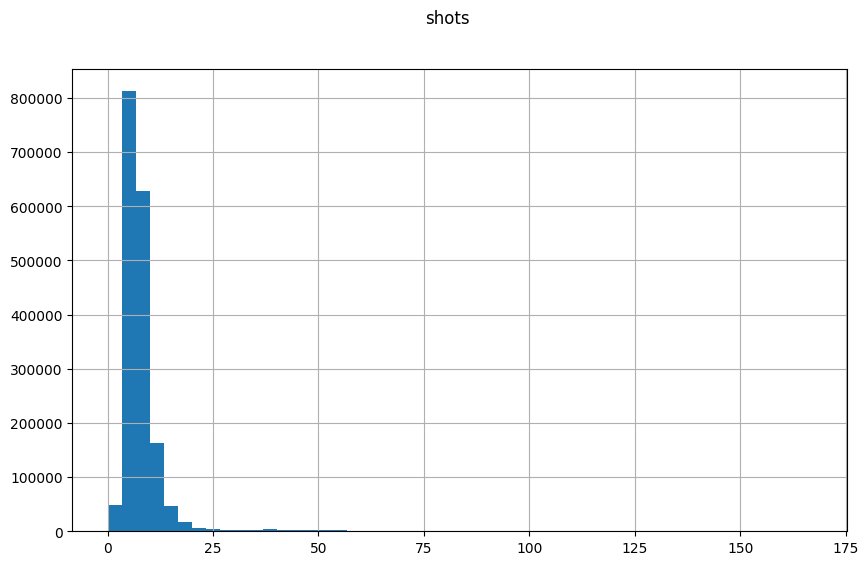

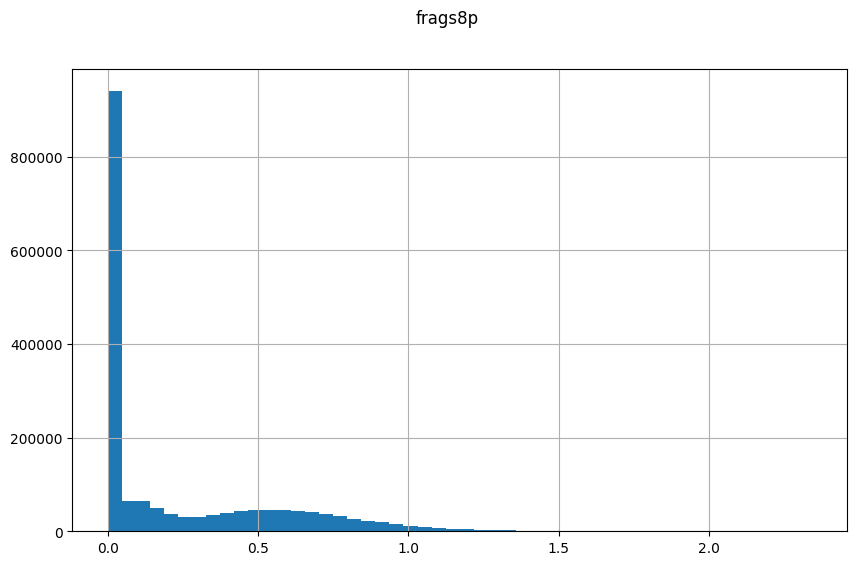

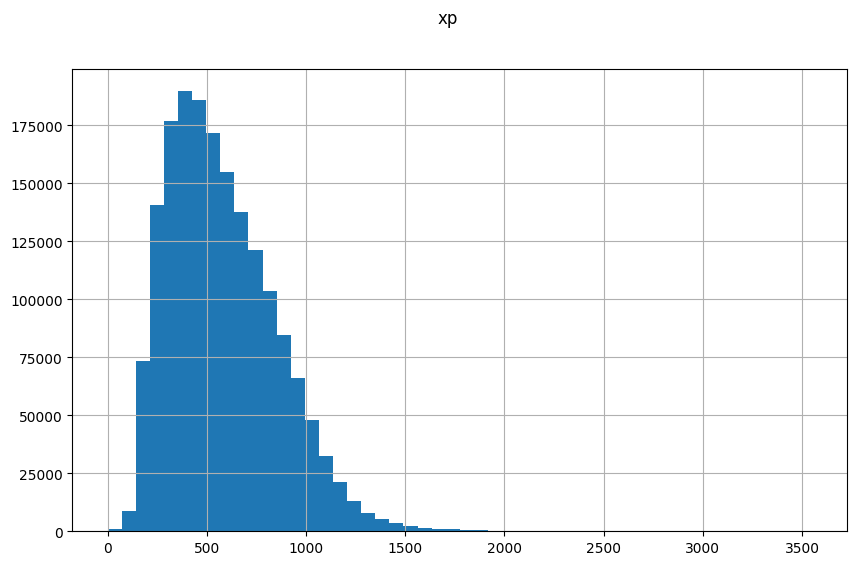

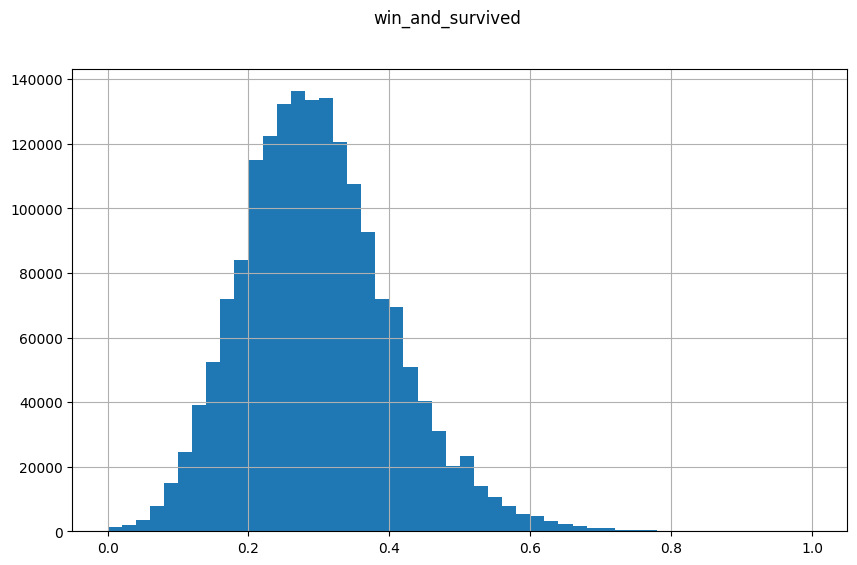

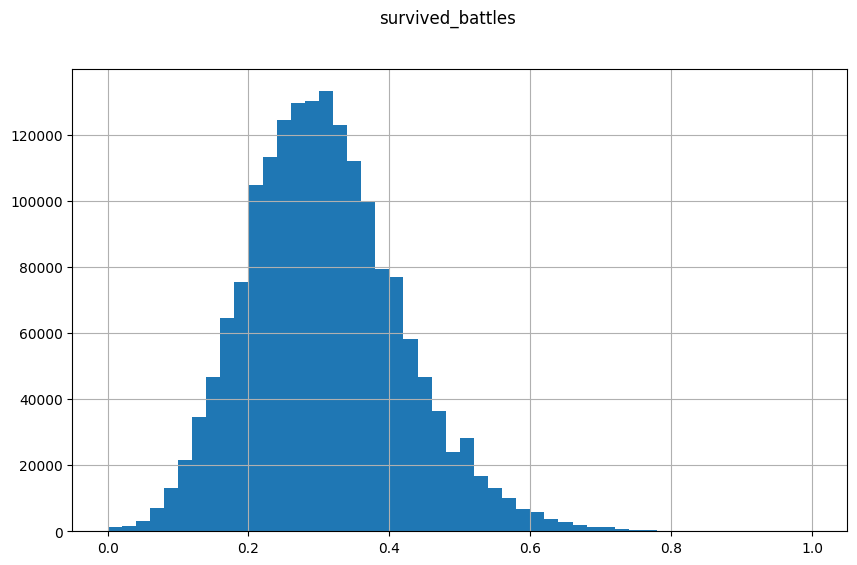

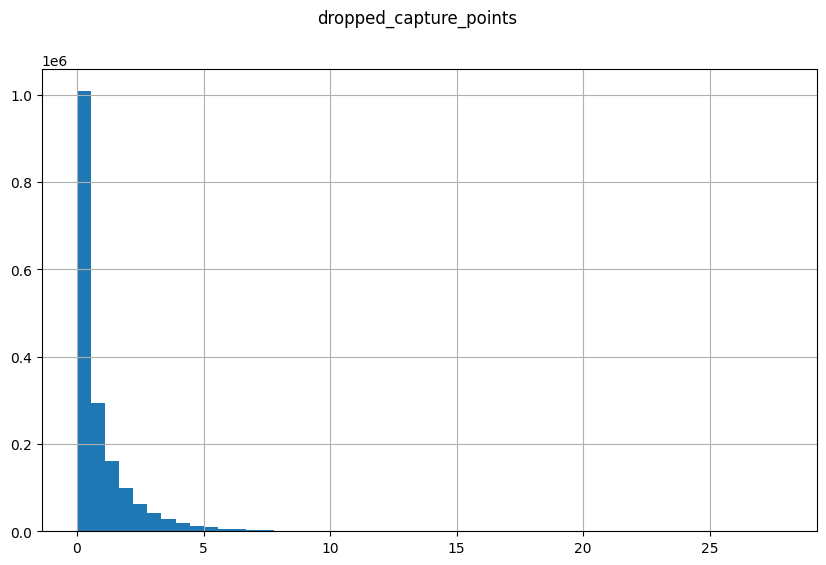

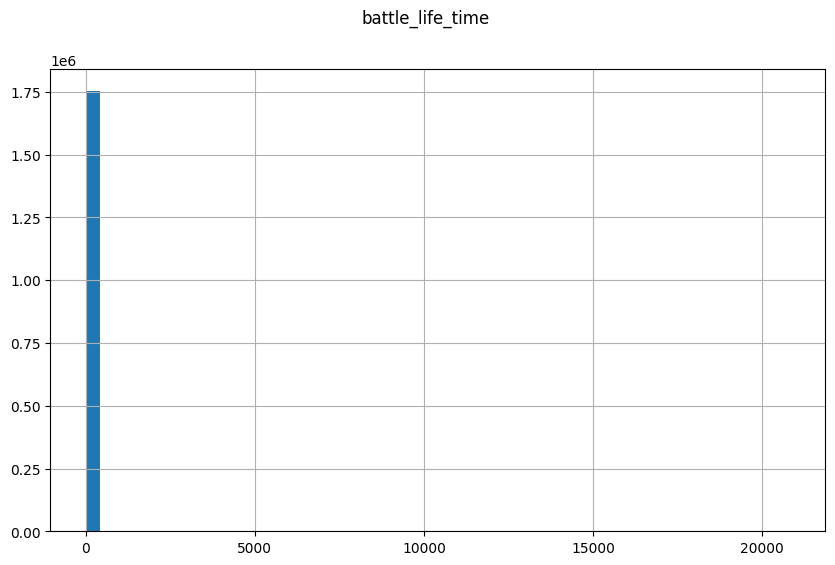

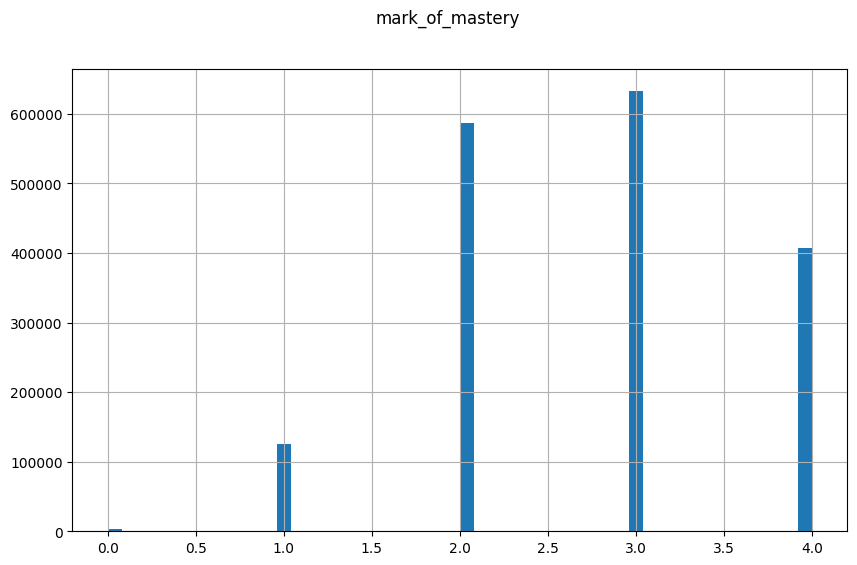

In [23]:
for col in df.drop(["user_id", "tank_id"], axis=1).columns:
    df.query("battles >= 30")[col].hist(bins=50, figsize=(10, 6))
    plt.suptitle(f"{col}")
    plt.show()

Как видим, отфильтровав танки с небольшим количеством боев, распределения данных еще больше приблизились к нормальным или логнормальным, а также мы избавились от шумовых данных. Это связано с тем, что чем меньше количество боев, тем больше влияние случайности (например, игроку могло не(повезти), игра могла закрыться сразу после загрузки в бой, а попасть обратно в тот же бой он не смог, из-за чего его полезность в бою была минимальна; или он мог сыграть только 2-3 боя в которых ему повезло с командой, но сам он ничего не успел сделать, например его убили с одного выстрела взорвав боеукладку или подпалив, а команда победила). Поэтмоу увеличивая минимальное количество боев мы получаем больше информации непосредственно о навыках владения танком игрока.
Таким образом, имеет смысл использовать данный фильтр и в дальнейшем.

In [24]:
# Отфильтруем данные прежде чем продолжать анализ
df = df.query("(battles >= 30) & (damage_dealt > 0)")

In [25]:
# Еще раз проверим по скольки премиум-танкам у нас остались данные после фильтрации
df[df.tank_id.isin(premium_df.tank_id.values)].tank_id.nunique()

282

In [26]:
# Еще раз проверим по скольки обычным танкам у нас остались данные после фильтрации
df[df.tank_id.isin(general_df.tank_id.values)].tank_id.nunique()

240

Теперь добавить к данным информацию о танках

In [27]:
full_tanks_df = pd.concat([general_df, premium_df]).reset_index(drop=True)

In [28]:
df = df.join(full_tanks_df.set_index("tank_id"), on="tank_id")

In [29]:
general_df

,tank_id,nation,tier,type,name
0,1,ussr,5,mediumTank,Т-34
1,17,germany,5,mediumTank,Pz.Kpfw. IV Ausf. G
2,1569,usa,7,mediumTank,T20
3,8225,usa,8,AT-SPG,T28
4,1297,germany,7,mediumTank,Panther I
...,...,...,...,...,...
235,3681,japan,10,mediumTank,STB-1
236,7505,uk,3,mediumTank,Cruiser Mk. IV
237,6273,european,7,mediumTank,Konštrukta T-34/100
238,20049,uk,8,lightTank,FV301


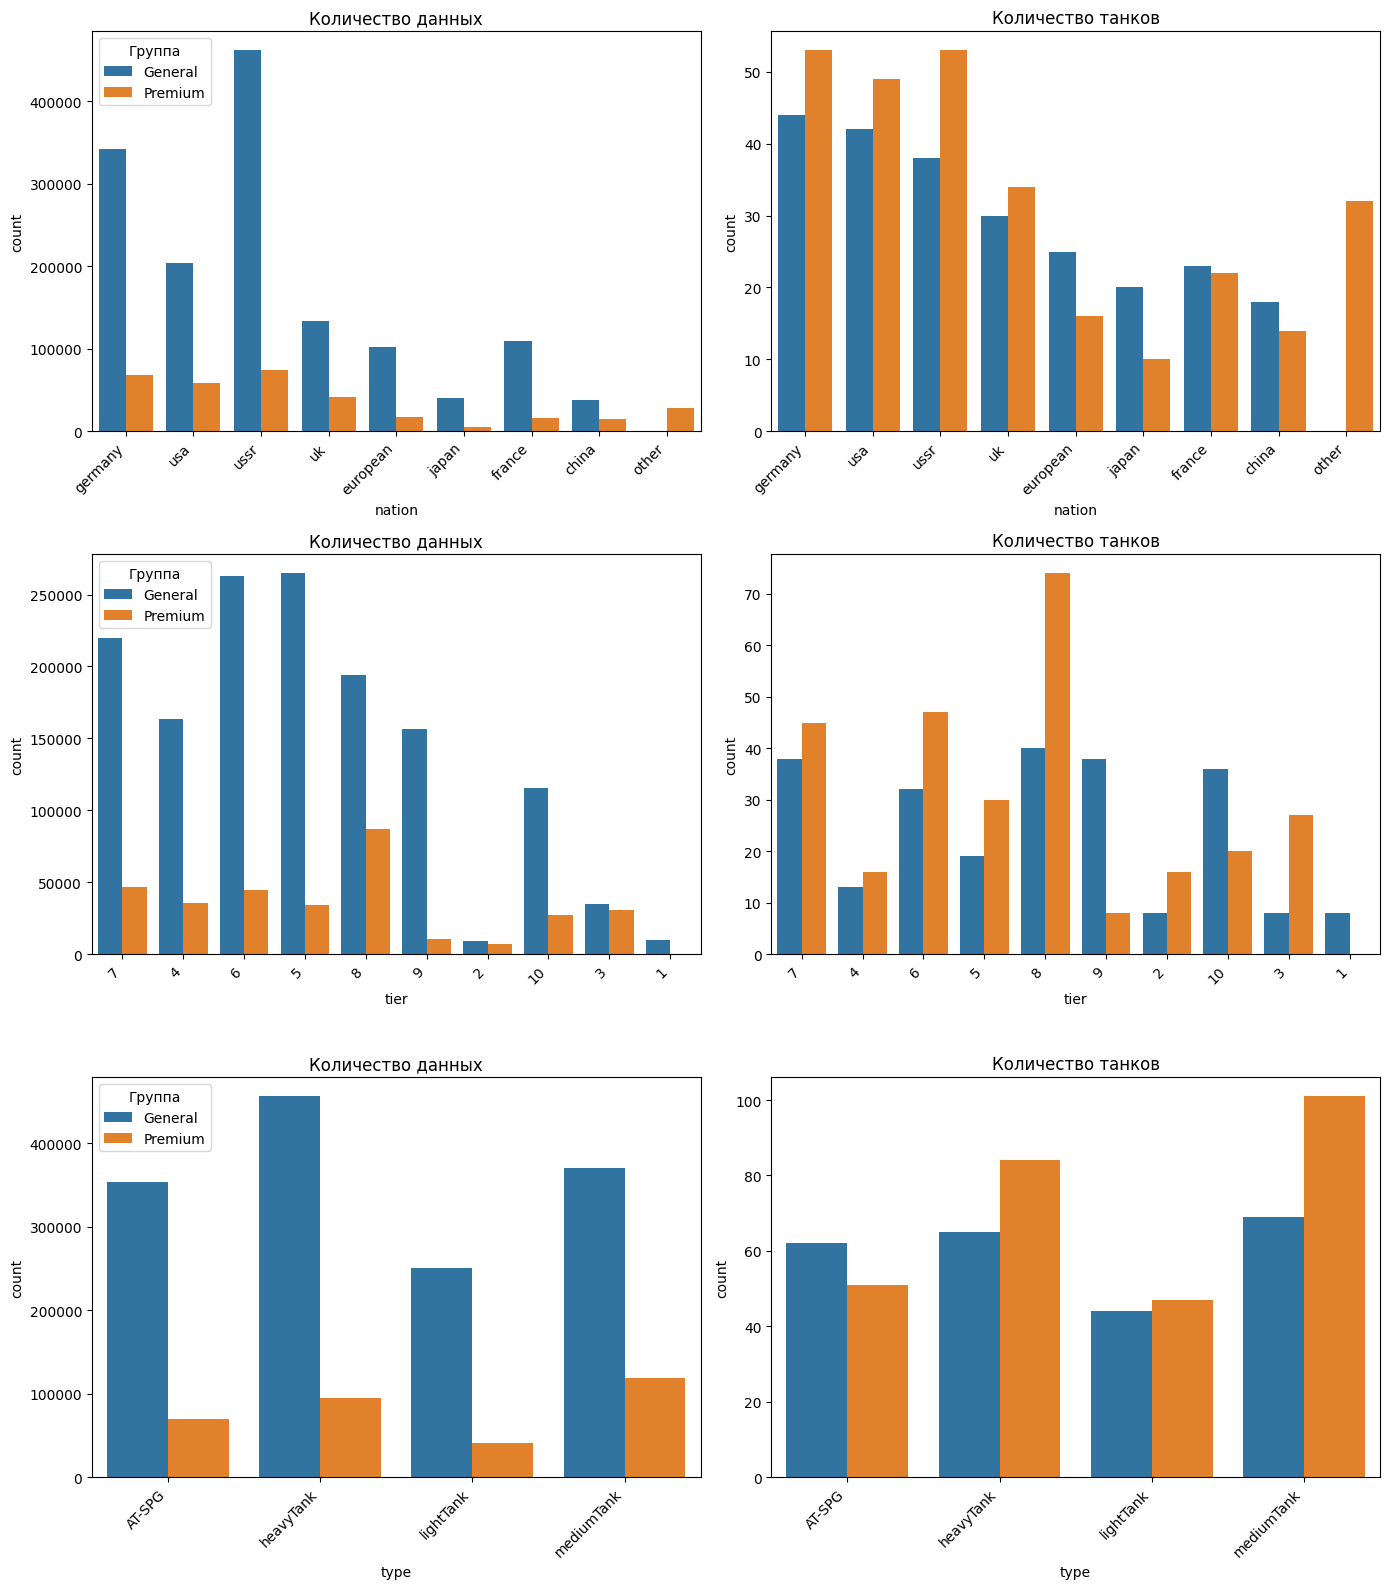

In [30]:
cols = ["nation", "tier", "type"]

labels1 = (
    df["tank_id"]
    .isin(premium_df.tank_id.values)
    .map({True: "Premium", False: "General"})
)
labels2 = (
    full_tanks_df["tank_id"]
    .isin(premium_df.tank_id.values)
    .map({True: "Premium", False: "General"})
)

fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(14, 16))

for i, col in enumerate(cols):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]

    order = list(
        dict.fromkeys(
            list(df[col].dropna().unique()) + list(full_tanks_df[col].dropna().unique())
        )
    )

    sns.countplot(data=df, x=col, hue=labels1, order=order, ax=ax1)
    ax1.set_title("Количество данных")
    sns.countplot(data=full_tanks_df, x=col, hue=labels2, order=order, ax=ax2)
    ax2.set_title("Количество танков")

    for a in (ax1, ax2):
        a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right")

    handles, legend_labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, legend_labels, title="Группа", loc="upper left")
    if ax2.get_legend() is not None:
        ax2.get_legend().remove()

plt.tight_layout()
plt.show()

Исходя из сравнения графиков можно заметить, что зачастую распределение количества танков совпадает с распределением записей об игре на них. Так, для премиум танков распределения очень похожи, в то время, как для обычных танков есть редкие исключения (например, хоть танков СССР и меньше, чем танков Германии или США, но записей по ним значитально больше, чем по танкам Германии и США, что скорее всего связано с тем, что мы рассматриваем данные СНГ региона; хоть танков 5 уровня существенно меньше, но данных по ним больше всего, что вероятнее всего связано с тем, что обычно с 5 уровня можно прокачать несколько танков к разным веткам танков 10-го уровня).

## Подготовка данных

Поскольку мы хотим использовать данные об игре на обычных танках в качестве фичей, а предсказывать средний урон на премиум-танках, то подготовим датасет.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1754654 entries, 0 to 84333
Data columns (total 62 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   user_id                                    int32  
 1   tank_id                                    int32  
 2   spotted                                    float32
 3   hits                                       float32
 4   frags                                      float32
 5   max_xp                                     int32  
 6   wins                                       float32
 7   losses                                     float32
 8   capture_points                             float32
 9   battles                                    int32  
 10  damage_dealt                               float32
 11  damage_received                            float32
 12  max_frags                                  int32  
 13  shots                                      float3

In [32]:
df = df.drop(["name", "default_profile.signal_range"], axis=1)
default_cols = [col for col in df.columns if "default_profile" in col]
df[default_cols] = df[default_cols].astype("float32")

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1754654 entries, 0 to 84333
Data columns (total 60 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   user_id                                    int32  
 1   tank_id                                    int32  
 2   spotted                                    float32
 3   hits                                       float32
 4   frags                                      float32
 5   max_xp                                     int32  
 6   wins                                       float32
 7   losses                                     float32
 8   capture_points                             float32
 9   battles                                    int32  
 10  damage_dealt                               float32
 11  damage_received                            float32
 12  max_frags                                  int32  
 13  shots                                      float3

In [34]:
general_data_df = df[df.tank_id.isin(general_df.tank_id)]
prem_data_df = df[df.tank_id.isin(premium_df.tank_id)]

In [35]:
del df

In [36]:
# убираем колонки с характеристиками обычных танков, т.к. они изменяются в зависимости от прокачки и мы не можем знать, на какой конфигурации играл игрок и сколько боев, поэтому используем аггрегированные данные
general_data_df = general_data_df.dropna(axis=1)
general_data_df

,user_id,tank_id,spotted,hits,frags,max_xp,wins,losses,capture_points,battles,...,frags8p,xp,win_and_survived,survived_battles,dropped_capture_points,battle_life_time,mark_of_mastery,nation,tier,type
0,53,11025,0.478873,3.809859,0.647887,1629,0.535211,0.464789,1.330986,142,...,0.105634,614.605652,0.302817,0.302817,0.732394,163.232391,4,germany,7,AT-SPG
4,53,1809,0.800000,4.650000,1.075000,1458,0.600000,0.400000,2.900000,40,...,0.000000,552.450012,0.525000,0.525000,0.700000,177.050003,4,germany,4,AT-SPG
5,53,11793,0.750000,6.000000,0.823529,1342,0.617647,0.382353,0.294118,68,...,0.000000,635.720581,0.397059,0.397059,0.044118,138.955887,3,germany,6,AT-SPG
49,59,5393,2.847826,59.956520,1.456522,993,0.695652,0.304348,0.000000,46,...,0.000000,534.326111,0.369565,0.369565,0.782609,127.173912,4,germany,5,lightTank
52,59,23329,1.600000,9.776470,0.776471,2001,0.517647,0.482353,0.105882,85,...,0.588235,748.929382,0.376471,0.376471,0.870588,174.199997,4,usa,8,heavyTank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84304,250453569,7185,0.566038,3.377358,0.396226,695,0.452830,0.528302,0.000000,53,...,0.000000,356.754730,0.075472,0.075472,0.056604,126.509438,1,germany,6,mediumTank
84305,250453569,11777,1.031250,4.312500,0.625000,759,0.546875,0.453125,0.265625,64,...,0.000000,398.296875,0.265625,0.265625,2.140625,144.218750,2,ussr,5,heavyTank
84320,250453822,11025,0.448000,4.408000,0.832000,1585,0.416000,0.576000,0.120000,125,...,0.008000,514.799988,0.272000,0.272000,0.264000,187.343994,4,germany,7,AT-SPG
84328,250453822,1041,1.393939,6.212121,0.939394,1224,0.575758,0.424242,0.000000,33,...,0.000000,594.393921,0.242424,0.242424,2.757576,125.787880,2,germany,5,AT-SPG


In [37]:
# удаляем категориальные колонки для обычных танков, т.к. они будут константными в зависимости от танка и не будут нести информации
general_data_df = general_data_df.drop(["nation", "tier", "type"], axis=1)

In [38]:
# преобразуем статистику игры на обычных танках в long формат для того, чтобы у нас была одна строка на пользователя
general_data_df = general_data_df.pivot(index="user_id", columns="tank_id")
general_data_df.columns = [
    "_".join([str(part) for part in col if part not in (None, "")])
    for col in general_data_df.columns
]
general_data_df.reset_index(inplace=True)

In [39]:
# для премиум танков наоборот оставляем колонки с характеристиками, категориальные и целевую переменную по нанесенному урону
prem_cols = (
    ["user_id", "tank_id"]
    + [col for col in prem_data_df.columns if "default_profile" in col]
    + ["nation", "tier", "type", "damage_dealt"]
)
prem_data_df = prem_data_df[prem_cols]

In [40]:
prem_data_df.tank_id.value_counts()[prem_data_df.tank_id.value_counts() >= 30]

tank_id
1537     7903
54785    7695
12321    7643
9297     5962
3073     4851
         ... 
11905      48
7025       42
55057      42
4465       38
52497      36
Name: count, Length: 272, dtype: int64

In [41]:
# Посчитаем средний урон для каждого прем-танка для бэйзлайна модели
avg_damage_dealt = prem_data_df.groupby("tank_id").damage_dealt.mean().to_dict()

In [42]:
# формируем финальный датасет из двух датафрэймов
final_df = general_data_df.merge(prem_data_df, on="user_id", how="inner")

In [91]:
joblib.dump(avg_damage_dealt, "avg_damage_dealt.joblib")

['avg_damage_dealt.joblib']

In [43]:
final_df.shape

(314485, 4602)

In [44]:
del general_data_df

In [45]:
gc.collect()

11598

In [46]:
# разделим данные так, чтобы один пользователь не мог быть и в тренировочном, и в тестовом датасетах
train_users, val_users = train_test_split(
    final_df.user_id.unique(), test_size=0.1, random_state=42
)
train_users, test_users = train_test_split(train_users, test_size=0.1, random_state=42)

In [47]:
train_ids = final_df.user_id.isin(train_users)
val_ids = final_df.user_id.isin(val_users)
test_ids = final_df.user_id.isin(test_users)

In [48]:
X_train = final_df[train_ids].drop("damage_dealt", axis=1)
y_train = final_df[train_ids]["damage_dealt"]

In [49]:
X_val = final_df[val_ids].drop("damage_dealt", axis=1)
y_val = final_df[val_ids]["damage_dealt"]

In [50]:
X_test = final_df[test_ids].drop("damage_dealt", axis=1)
y_test = final_df[test_ids]["damage_dealt"]

In [51]:
train_tank_ids = X_train.tank_id
val_tank_ids = X_val.tank_id
test_tank_ids = X_test.tank_id

In [52]:
X_train.drop(["user_id", "tank_id"], axis=1, inplace=True)
X_val.drop(["user_id", "tank_id"], axis=1, inplace=True)
X_test.drop(["user_id", "tank_id"], axis=1, inplace=True)

In [53]:
del final_df

In [54]:
cat_cols = [col for col in X_train.columns if "mark_of_mastery" in col] + [
    "nation",
    "tier",
    "type",
]
num_cols = [col for col in X_train.columns if col not in cat_cols]

In [55]:
X_train[cat_cols] = X_train[cat_cols].astype('category')
X_val[cat_cols] = X_val[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

In [57]:
means = np.nanmean(X_train[num_cols], axis=0)
stds = np.nanstd(X_train[num_cols], axis=0)
stds[stds == 0] = 1.0

In [58]:
joblib.dump(means, "means.joblib")
joblib.dump(stds, "stds.joblib")

['stds.joblib']

In [59]:
def scale_data(data, means, stds):
    n = data.shape[0]
    X_values = data.to_numpy(dtype=np.float32)
    step = 10000
    for i in tqdm(range(0, n, step)):
        X_values[i : i + step] = (X_values[i : i + step] - means) / stds

    return X_values

In [60]:
X_train[num_cols] = scale_data(X_train[num_cols], means, stds)
X_val[num_cols] = scale_data(X_val[num_cols], means, stds)
X_test[num_cols] = scale_data(X_test[num_cols], means, stds)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.90it/s]


In [61]:
# ограничиваем обучающую выборку из-за ограниченности ресурсов
train_tank_ids = train_tank_ids.sample(frac=0.05, random_state=42)
X_train = X_train.sample(frac=0.05, random_state=42)
y_train = y_train.sample(frac=0.05, random_state=42)

## Моделирование

Посмотрим на первый baseline, когда мы предсказываем для премиум-танков просто средний урон по этим танкам.

In [62]:
# Метрики на обучающей выборке
preds = train_tank_ids.map(avg_damage_dealt)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

R2-score: 0.755
RMSE: 283.307
MAE: 208.332
MAPE: 0.249


In [63]:
# Метрики на валидационной выборке
preds = val_tank_ids.map(avg_damage_dealt)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

R2-score: 0.760
RMSE: 282.220
MAE: 206.867
MAPE: 0.250


In [64]:
# Метрики на тестовой выборке
preds = test_tank_ids.map(avg_damage_dealt)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

R2-score: 0.747
RMSE: 288.728
MAE: 210.176
MAPE: 0.244


Построим модель посложнее.

In [65]:
simple_model = HistGradientBoostingRegressor(random_state=42)

In [66]:
simple_model.fit(X_train, y_train)

,loss,'squared_error'
,quantile,None
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [67]:
joblib.dump(simple_model, "hist_gbr.joblib")

['hist_gbr.joblib']

In [68]:
preds = simple_model.predict(X_train)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

R2-score: 0.944
RMSE: 135.845
MAE: 97.226
MAPE: 0.130


In [69]:
preds = simple_model.predict(X_val)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

R2-score: 0.896
RMSE: 185.370
MAE: 134.191
MAPE: 0.172


In [70]:
preds = simple_model.predict(X_test)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

R2-score: 0.894
RMSE: 186.443
MAE: 133.377
MAPE: 0.164


Теперь обучим более сложную модель с подбором параметров

In [71]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": trial.suggest_categorical("boosting", ["gbdt", "dart"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 30, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "subsample": trial.suggest_uniform("subsample", 0.4, 1),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1),
        "verbosity": -1,
        "seed": 42,
        "n_jobs": 4,
    }

    model = lgb.LGBMRegressor(**params)
    early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=False)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[early_stopping_callback],
    )
    preds = model.predict(X_val, num_iteration=model.best_iteration_)
    rmse = root_mean_squared_error(y_val, preds)

    return rmse

In [72]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
)
study.optimize(objective, n_trials=30, n_jobs=4)

[I 2025-11-21 21:32:38,858] A new study created in memory with name: no-name-78e5a199-5c85-4f19-9299-e652673960fc
[I 2025-11-21 21:35:54,931] Trial 2 finished with value: 215.42214164331864 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.01766879682139516, 'n_estimators': 119, 'num_leaves': 66, 'max_depth': 13, 'min_child_samples': 92, 'subsample': 0.8869717229325256, 'colsample_bytree': 0.8700625277954681, 'reg_alpha': 2.973460783645048e-05, 'reg_lambda': 0.3297058004121128}. Best is trial 2 with value: 215.42214164331864.
[I 2025-11-21 21:36:49,031] Trial 3 finished with value: 827.711773843878 and parameters: {'boosting': 'dart', 'learning_rate': 0.002630027019285404, 'n_estimators': 442, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 106, 'subsample': 0.8041866524715091, 'colsample_bytree': 0.26105524163294797, 'reg_alpha': 2.553270735729159e-07, 'reg_lambda': 0.15457741231627245}. Best is trial 2 with value: 215.42214164331864.
[I 2025-11-21 21:37:10,225] Trial 0 f

In [73]:
print("Best RMSE", study.best_value)
print("Best params", study.best_params)

Best RMSE 179.8143594384864
Best params {'boosting': 'gbdt', 'learning_rate': 0.01557701136034225, 'n_estimators': 957, 'num_leaves': 51, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.7309367945787189, 'colsample_bytree': 0.3151218967190487, 'reg_alpha': 8.972383237815721e-08, 'reg_lambda': 8.186697555369474e-06}


In [74]:
lgb_model = lgb.LGBMRegressor(**study.best_params)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="rmse")

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 949510
[LightGBM] [Info] Number of data points in the train set: 12769, number of used features: 4598
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Start training from score 1062.034558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

,boosting_type,'gbdt'
,num_leaves,51
,max_depth,13
,learning_rate,0.01557701136034225
,n_estimators,957
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,7


In [75]:
joblib.dump(lgb_model, "lgb_optuna.joblib")

['lgb_optuna.joblib']

In [76]:
preds = lgb_model.predict(X_train)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
R2-score: 0.970
RMSE: 99.949
MAE: 71.160
MAPE: 0.100


In [77]:
preds = lgb_model.predict(X_val)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
R2-score: 0.903
RMSE: 179.823
MAE: 129.156
MAPE: 0.165


In [78]:
preds = lgb_model.predict(X_test)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
R2-score: 0.900
RMSE: 181.742
MAE: 128.890
MAPE: 0.158


In [79]:
ag_train = TabularDataset(
    pd.concat([X_train, y_train], axis=1),
)
ag_val = TabularDataset(
    pd.concat([X_val, y_val], axis=1)
)
ag_test = TabularDataset(X_test)

In [80]:
label = "damage_dealt"

In [81]:
predictor = TabularPredictor(label=label).fit(ag_train, tuning_data=ag_val, num_cpus=4, time_limit=600)

No path specified. Models will be saved in: "AutogluonModels\ag-20251121_191525"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
Memory Avail:       22.07 GB / 31.89 GB (69.2%)
Disk Space Avail:   296.95 GB / 1862.96 GB (15.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize a

In [82]:
joblib.dump(predictor, "autogluon_model.joblib")

['autogluon_model.joblib']

In [83]:
preds = predictor.predict(ag_train)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

R2-score: 0.974
RMSE: 92.343
MAE: 63.366
MAPE: 0.088


In [84]:
preds = predictor.predict(ag_val)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

R2-score: 0.905
RMSE: 177.693
MAE: 127.922
MAPE: 0.162


In [85]:
preds = predictor.predict(ag_test)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

R2-score: 0.902
RMSE: 179.489
MAE: 127.431
MAPE: 0.155


In [86]:
automl = AutoML()
automl.fit(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    task="regression",
    max_iter=30,
    seed=42,
    n_jobs=4,
)

[flaml.automl.logger: 11-21 22:38:02] {1752} INFO - task = regression
[flaml.automl.logger: 11-21 22:38:02] {1760} INFO - Data split method: uniform
[flaml.automl.logger: 11-21 22:38:02] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 11-21 22:38:03] {1862} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 11-21 22:38:04] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost']
[flaml.automl.logger: 11-21 22:38:04] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 11-21 22:38:22] {2417} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 11-21 22:38:22] {2466} INFO -  at 58.9s,	estimator lgbm's best error=0.6178,	best estimator lgbm's best error=0.6178
[flaml.automl.logger: 11-21 22:38:22] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-21 22:38:41] {2466} INFO -  at 77.8s,	estimator lgbm's best 

In [87]:
joblib.dump(automl, "flaml_model.joblib")

['flaml_model.joblib']

In [88]:
preds = automl.predict(X_train)
print(f"R2-score: {r2_score(y_train, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_train, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_train, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, preds):.3f}")

R2-score: 0.925
RMSE: 157.224
MAE: 114.939
MAPE: 0.151


In [89]:
preds = automl.predict(X_val)
print(f"R2-score: {r2_score(y_val, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_val, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_val, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, preds):.3f}")

R2-score: 0.890
RMSE: 191.273
MAE: 138.683
MAPE: 0.180


In [90]:
preds = automl.predict(X_test)
print(f"R2-score: {r2_score(y_test, preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, preds):.3f}")

R2-score: 0.889
RMSE: 191.223
MAE: 136.550
MAPE: 0.172


## Итоги моделирования

В ходе моделирования были получены следующие результаты:
|Модель|$R^2$|RMSE|MAE|MAPE|Время обучения|Размер файла модели|
| :------- | :------: | :------: | :------: | :------: |:------:|:------:|
|Baseline (среднее по танку)|0.747|288.728|210.176|0.244|const|3.3 KB|
|HistGradientBoostingRegressor|0.894|186.443|133.377|0.164|48.23s|8.4 MB|
|LGBMRegressor + Optuna|0.9|181.742|128.890|0.158|40m 20.93s|4.8 MB|
|AutoGluon|0.902|179.489|127.431|0.155|21m 24.58s|1.9 MB|
|Flaml AutoML|0.889|191.223|136.550|0.172|42m 25.21s|1.9 MB|

Если не учитывать baseline, то можно заметить, что лучшей моделью по метрикам и размеру файла модели является модель, обученная при помощи AutoGluon, уступая по времени обучения только HistGradientBoostingRegressor (которая не отличалась стабильностью, т.к. от запуска к запуску время обучения разнилось от 40 секунд до 6 минут). Исходя из этого, наиболее оптимальным будет использование модели, обученной при помощи AutoGluon.